In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

load results from ann-benchmarks

In [2]:
#old: csv_path  = "/local/home/vmageirakos/projects/crack-vdb/others/ann-benchmarks/res-sift-128-euclidean.csv"
csv_path  = "./results/annbench-sift-results.csv"

In [3]:
df = pd.read_csv(csv_path)

In [4]:
# Filter rows where 'k-nn' > 0.9
fdf = df[((df['k-nn'] >= 0.90) & (df['k-nn'] < 0.99)) | (df['algorithm'] == 'bruteforce-blas')]

# fdf = fdf[fdf['algorithm'].isin(['faiss-ivf', 'bruteforce-blas'])]
# fdf = fdf[fdf['algorithm'].isin(['faiss-ivf', 'bruteforce-blas', 'hnsw(faiss)'])]
# fdf = fdf[fdf['algorithm'].isin(['faiss-ivf', 'bruteforce-blas', 'parlayann', 'flann', 'hnsw(faiss)','hnswlib'])]
fdf.columns
# # Display the filtered DataFrame
# fdf['search_time_ms'] = 1000/fdf['qps']
# fdf['build_time_ms'] = fdf['build']
# fdf['add_time_ms'] = 0


Index(['algorithm', 'parameters', 'count', 'k-nn', 'epsilon', 'largeepsilon',
       'rel', 'qps', 'p50', 'p95', 'p99', 'p999', 'distcomps', 'build',
       'candidates', 'indexsize', 'queriessize', 'dataset'],
      dtype='object')

In [37]:
fdf.algorithm.value_counts()

algorithm
weaviate            29
pynndescent         20
hnsw(faiss)         20
parlayann           19
hnswlib             12
nndescent           10
hnsw(nmslib)         9
NGT-qg               6
redisearch           5
SW-graph(nmslib)     5
opensearchknn        3
faiss-ivf            3
faiss-ivfpqfs        3
pgvecto_rs           2
bruteforce-blas      2
flann                1
NGT-panng            1
Name: count, dtype: int64

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

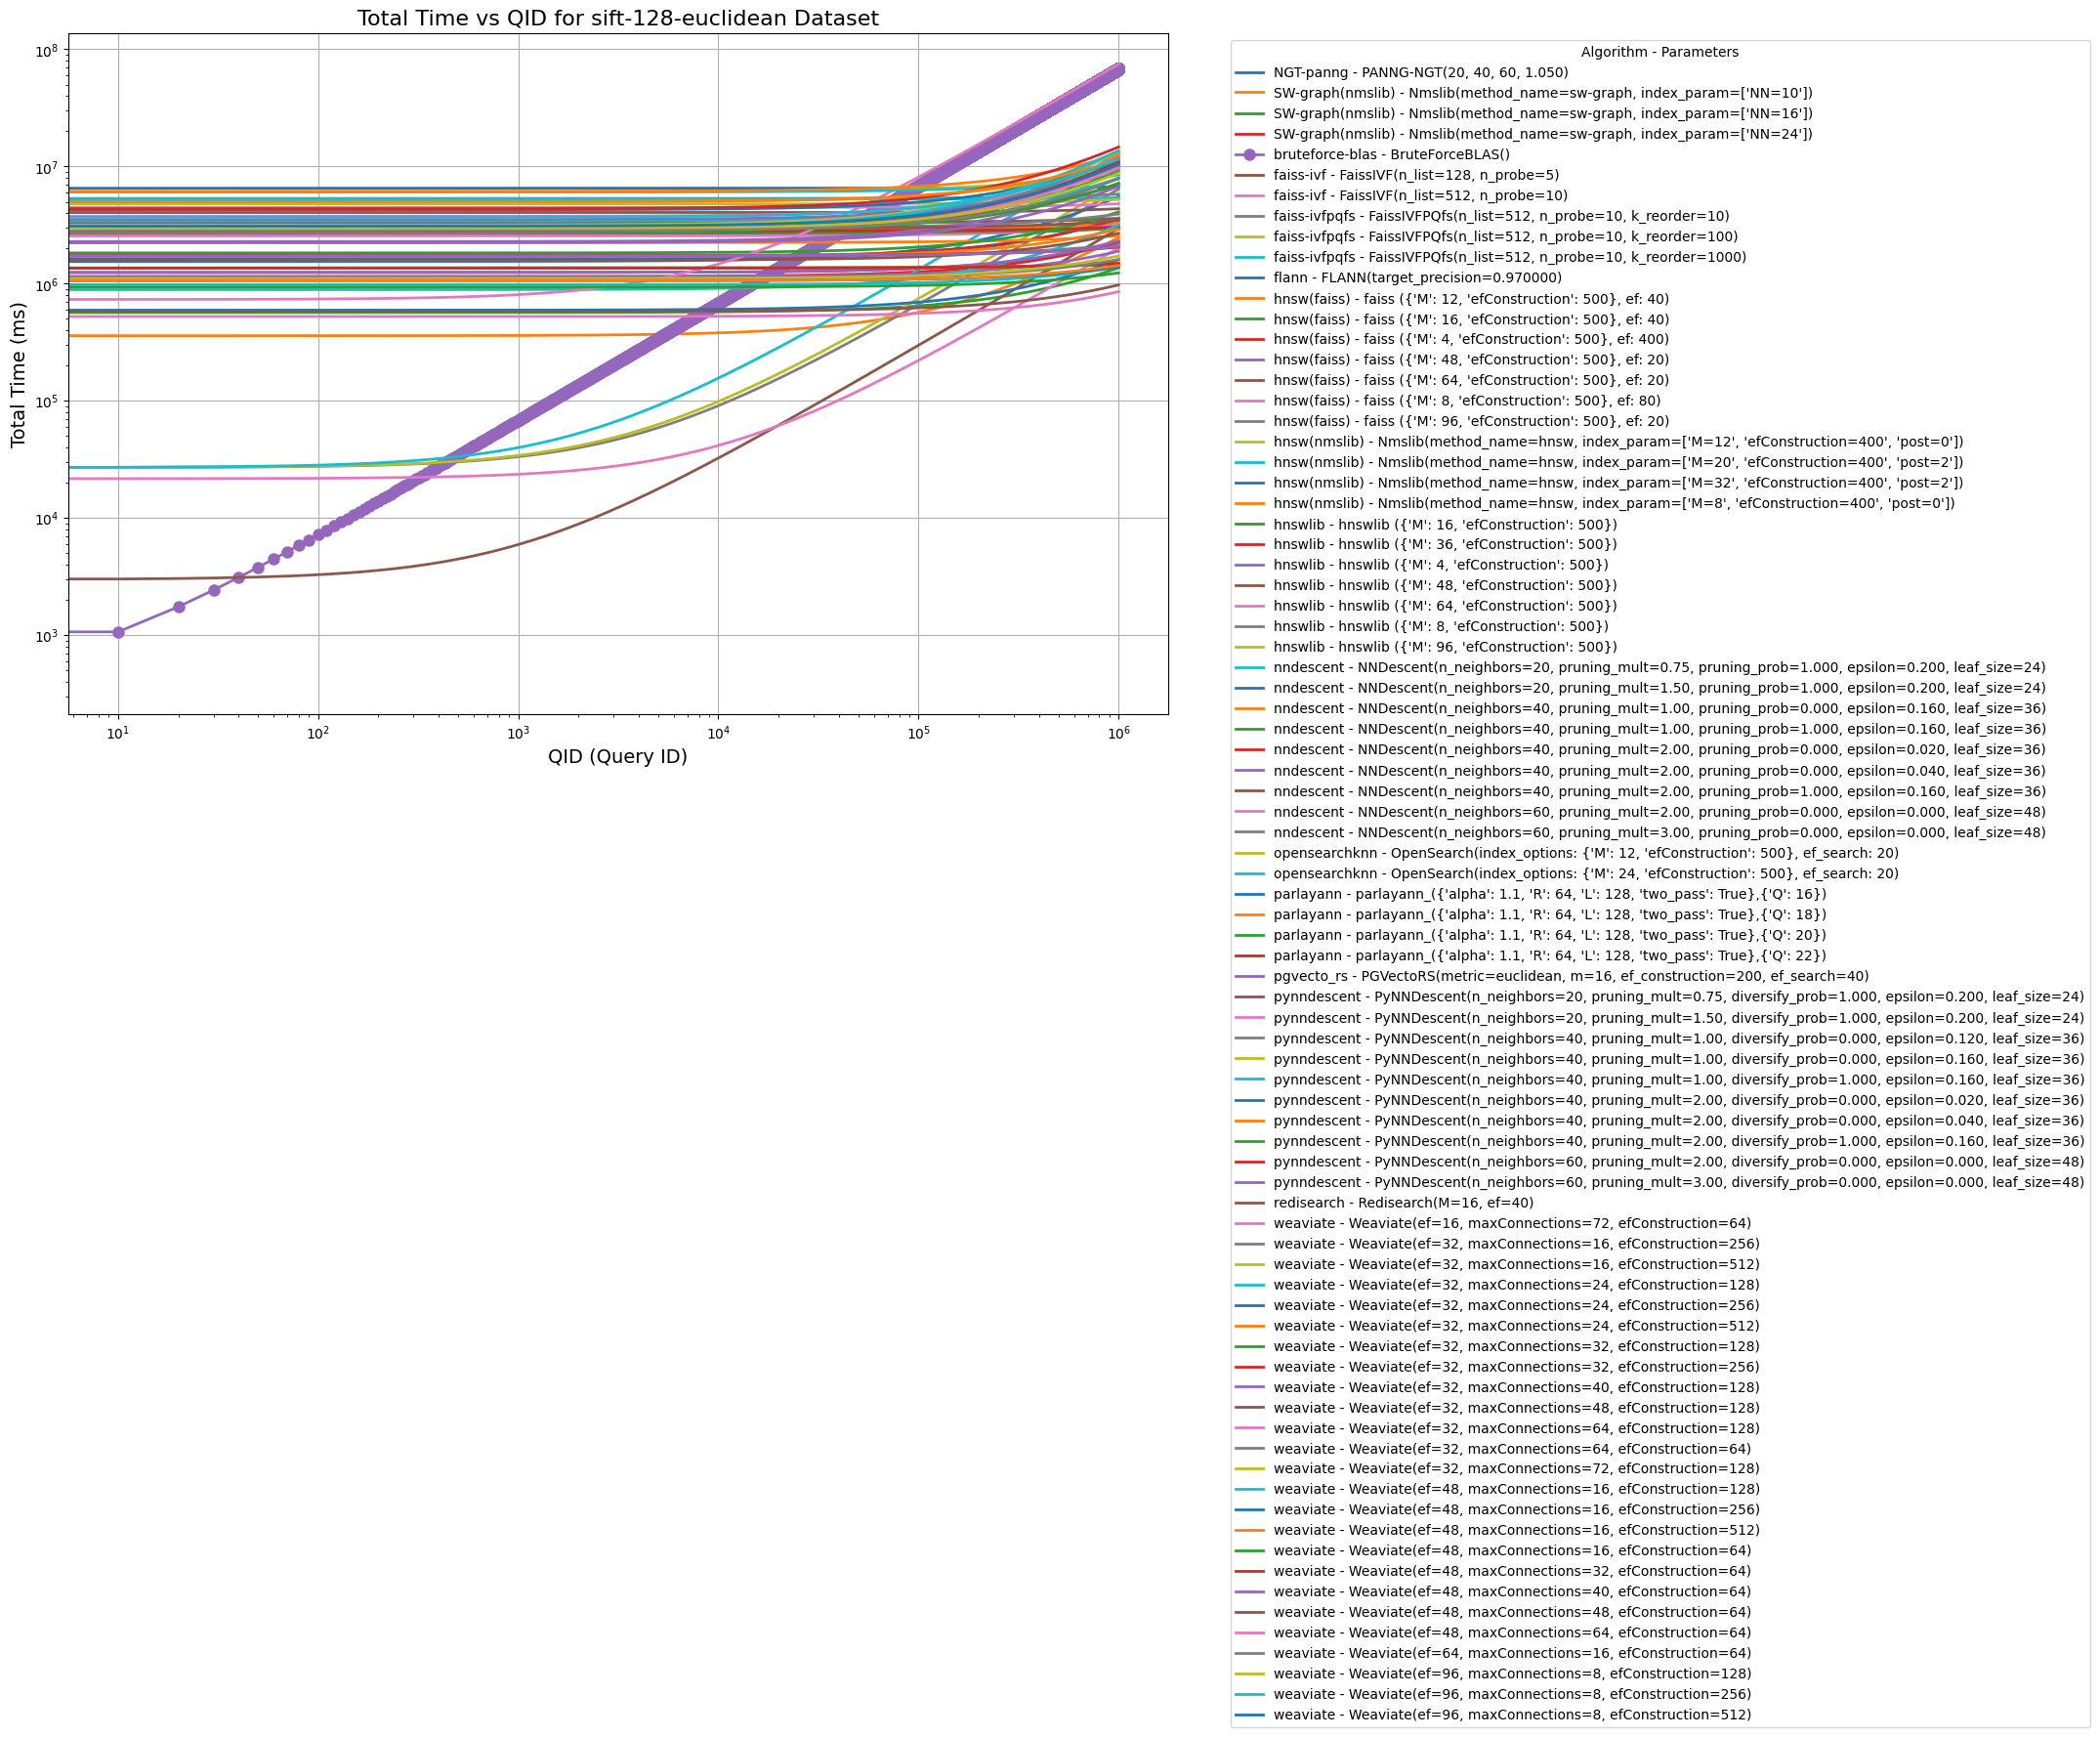

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming fdf is the DataFrame with the given columns
# fdf should be pre-loaded with data that includes columns like 'algorithm', 'parameters', 'qps', 'build', 'dataset', etc.

# Number of queries and query IDs
num_queries = 1_000_000
step = 10
start_qid = 0
query_ids = np.arange(start_qid, num_queries + 1, step) # if you want to skip some of them do num_queries + X (skip X to get the plot faster)

# Loop through each dataset
for dataset_name, dataset_df in fdf.groupby('dataset'):
    # Create a new plot for each dataset
    plt.figure(figsize=(12, 8))
    if dataset_name not in ['sift-128-euclidean']: continue
    # Loop through each algorithm and parameters within the dataset
    for (algo_name, params), group in dataset_df.groupby(['algorithm', 'parameters']):
        # Extract values for build time and qps for the current algorithm
        build_time = group['build'].iloc[0] * 1000  # convert to ms (build time in seconds)
        qps = group['qps'].iloc[0]
        
        # Calculate search time per query (in ms)
        search_time_per_query = 1000 / qps
        
        # Compute total time for each query
        total_time = build_time + query_ids * search_time_per_query
        
        # Check if 'bruteforce-blas' is in the parameters
        if any(substring in params for substring in ['BruteForceBLAS()', 'FaissIVF(n_list=4096, n_probe=50)', 'FaissIVF(n_list=4096, n_probe=100)']):
            # Use a special marker for bruteforce-blas
            marker_style = 'o'  # o, s, 
            markersize = 8
            # marker_style = None
        elif any(substring in algo_name for substring in ['hnsw(faiss)']):
            marker_style = None
            markersize = 2
        else:
            # Use no marker for other algorithms
            marker_style = None
            markersize = None
        
        # Plot total time vs query id, color by parameters and special marker if applicable
        # plt.plot(query_ids, total_time, label=f"{algo_name} - {params}", linestyle='-', marker=marker_style)
        plt.plot(query_ids, total_time, label=f"{algo_name} - {params}", linestyle='-', marker=marker_style, markersize=markersize, linewidth=2)


    # Add labels, title, and legend
    plt.title(f'Total Time vs QID for {dataset_name} Dataset', fontsize=16)
    plt.xlabel('QID (Query ID)', fontsize=14)
    plt.ylabel('Total Time (ms)', fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Place the legend outside the plot
    plt.legend(title='Algorithm - Parameters', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set the y-axis to logarithmic scale
    plt.yscale('log')
    plt.xscale('log')

    # Show the plot for the current dataset
    plt.show()

Colour based on algo name:

/tmp/ipykernel_922510/4196262789.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

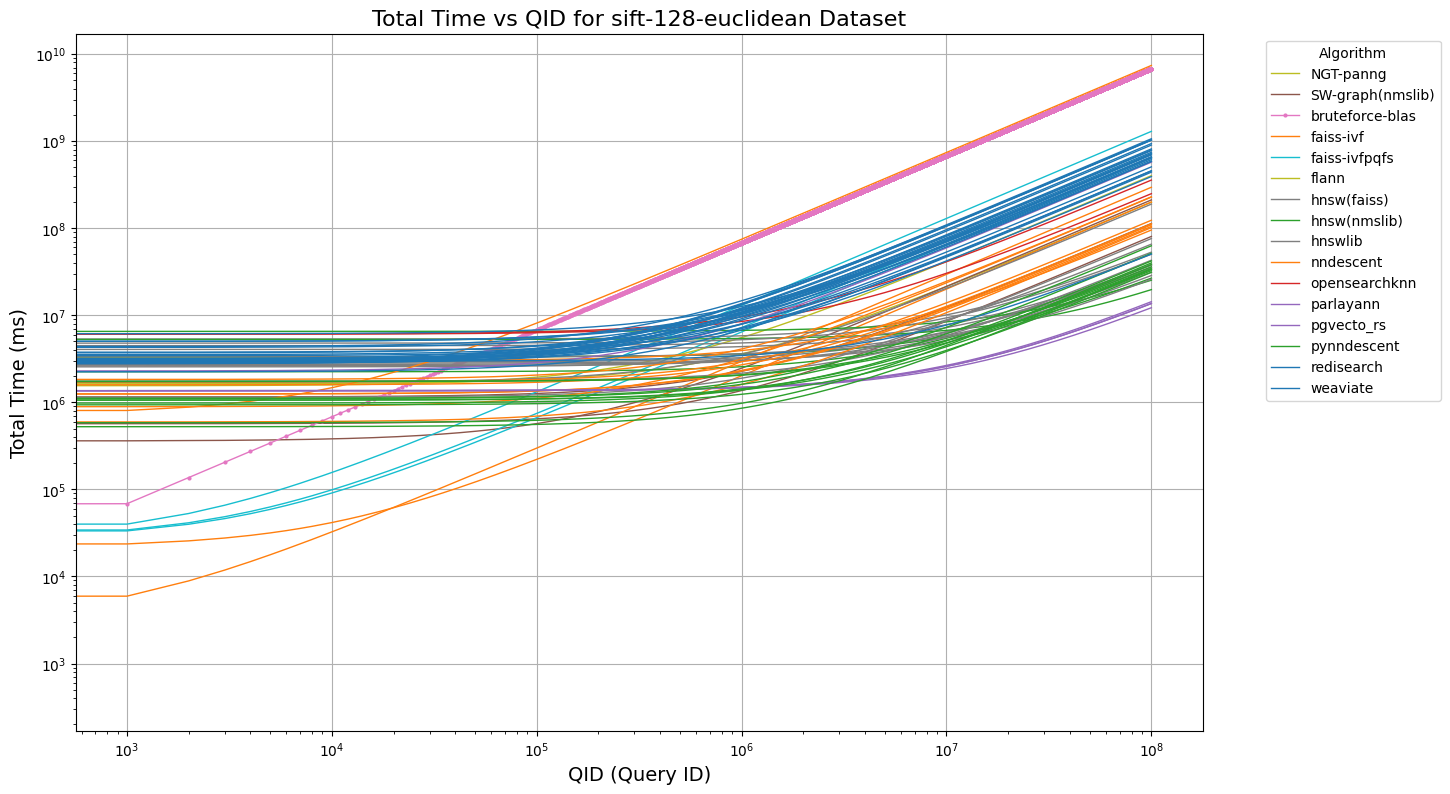

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming fdf is the DataFrame with the given columns
# fdf should be pre-loaded with data that includes columns like 'algorithm', 'parameters', 'qps', 'build', 'dataset', etc.

# Number of queries and query IDs
num_queries = 100_000_000
step = 1000
start_qid = 0
query_ids = np.arange(start_qid, num_queries + 1, step)  # if you want to skip some of them do num_queries + X (skip X to get the plot faster)

# Create a color map: assign a unique color to each algorithm name
unique_algos = fdf['algorithm'].unique()
# hsv, tab10, Set3, tab20
color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}

# Loop through each dataset
for dataset_name, dataset_df in fdf.groupby('dataset'):
    # Create a new plot for each dataset
    plt.figure(figsize=(12, 8))
    
    # Skip dataset if not in the list
    if dataset_name not in ['sift-128-euclidean']: continue
    
    # Set to track algorithms already plotted
    plotted_algos = set()

    # Loop through each algorithm and parameters within the dataset
    for (algo_name, params), group in dataset_df.groupby(['algorithm', 'parameters']):
        # Extract values for build time and qps for the current algorithm
        build_time = group['build'].iloc[0] * 1000  # convert to ms (build time in seconds)
        qps = group['qps'].iloc[0]
        
        # Calculate search time per query (in ms)
        search_time_per_query = 1000 / qps
        
        # Compute total time for each query
        total_time = build_time + query_ids * search_time_per_query
        
        # Check if 'bruteforce-blas' is in the parameters
        if any(substring in params for substring in ['BruteForceBLAS()', 'FaissIVF(n_list=4096, n_probe=50)', 'FaissIVF(n_list=4096, n_probe=100)']):
            # Use a special marker for bruteforce-blas
            marker_style = 'o'  # Circle marker
            markersize = 2
        elif any(substring in algo_name for substring in ['hnsw(faiss)']):
            marker_style = None
            markersize = None
        else:
            # Use no marker for other algorithms
            marker_style = None
            markersize = None
        
        # Plot total time vs query id, color by parameters and special marker if applicable
        color = color_map[algo_name]  # Use the assigned color for this algorithm
        
        # Add to legend only once per algorithm
        if algo_name not in plotted_algos:
            label = algo_name  # Add label only the first time this algorithm is plotted
            plotted_algos.add(algo_name)
        else:
            label = None  # No label for subsequent occurrences of the same algorithm
        
        plt.plot(query_ids, total_time, 
                 label=label,  # Only label the first occurrence
                 linestyle='-', 
                 marker=marker_style, 
                 markersize=markersize, 
                 linewidth=1, 
                 color=color)  # Apply color based on algorithm name

    # Add labels, title, and legend
    plt.title(f'Total Time vs QID for {dataset_name} Dataset', fontsize=16)
    plt.xlabel('QID (Query ID)', fontsize=14)
    plt.ylabel('Total Time (ms)', fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Place the legend outside the plot
    plt.legend(title='Algorithm', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set the y-axis to logarithmic scale
    plt.yscale('log')
    plt.xscale('log')

    # Show the plot for the current dataset
    plt.show()


/tmp/ipykernel_922510/4143743135.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

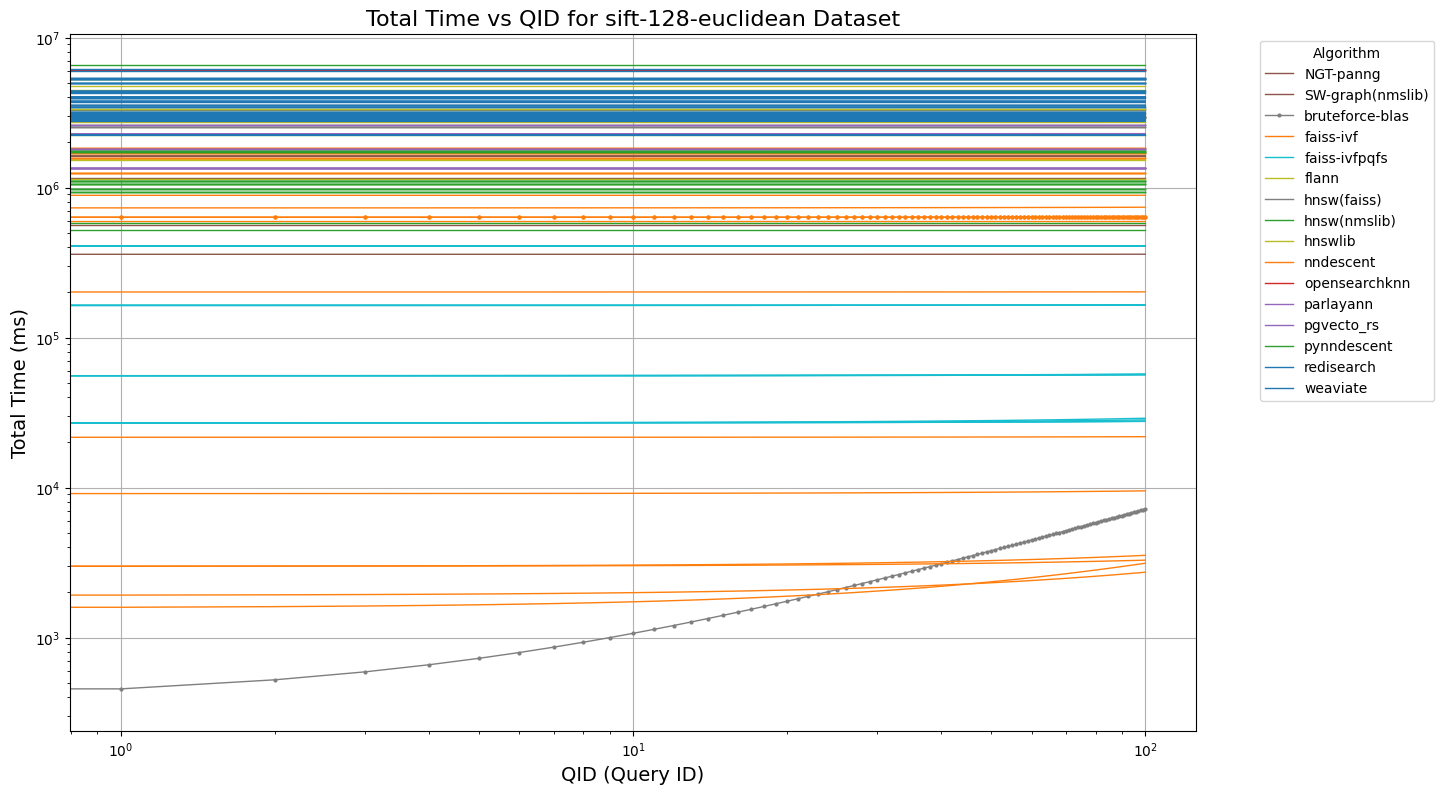

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming fdf is the DataFrame with the given columns
# fdf should be pre-loaded with data that includes columns like 'algorithm', 'parameters', 'qps', 'build', 'dataset', etc.

# Number of queries and query IDs
num_queries = 100
step = 1
start_qid = 0
query_ids = np.arange(start_qid, num_queries + 1, step)  # if you want to skip some of them do num_queries + X (skip X to get the plot faster)

# Create a color map: assign a unique color to each algorithm name
unique_algos = fdf['algorithm'].unique()
# hsv, tab10, Set3, tab20
color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}

# Loop through each dataset
for dataset_name, dataset_df in fdf.groupby('dataset'):
    # Create a new plot for each dataset
    plt.figure(figsize=(12, 8))
    
    # Skip dataset if not in the list
    if dataset_name not in ['sift-128-euclidean']: continue
    
    # Set to track algorithms already plotted
    plotted_algos = set()

    # Loop through each algorithm and parameters within the dataset
    for (algo_name, params), group in dataset_df.groupby(['algorithm', 'parameters']):
        # Extract values for build time and qps for the current algorithm
        build_time = group['build'].iloc[0] * 1000  # convert to ms (build time in seconds)
        qps = group['qps'].iloc[0]
        
        # Calculate search time per query (in ms)
        search_time_per_query = 1000 / qps
        
        # Compute total time for each query
        total_time = build_time + query_ids * search_time_per_query
        
        # Check if 'bruteforce-blas' is in the parameters
        if any(substring in params for substring in ['BruteForceBLAS()', 'FaissIVF(n_list=4096, n_probe=50)', 'FaissIVF(n_list=4096, n_probe=100)']):
            # Use a special marker for bruteforce-blas
            marker_style = 'o'  # Circle marker
            markersize = 2
        elif any(substring in algo_name for substring in ['hnsw(faiss)']):
            marker_style = None
            markersize = None
        else:
            # Use no marker for other algorithms
            marker_style = None
            markersize = None
        
        # Plot total time vs query id, color by parameters and special marker if applicable
        color = color_map[algo_name]  # Use the assigned color for this algorithm
        
        # Add to legend only once per algorithm
        if algo_name not in plotted_algos:
            label = algo_name  # Add label only the first time this algorithm is plotted
            plotted_algos.add(algo_name)
        else:
            label = None  # No label for subsequent occurrences of the same algorithm
        
        plt.plot(query_ids, total_time, 
                 label=label,  # Only label the first occurrence
                 linestyle='-', 
                 marker=marker_style, 
                 markersize=markersize, 
                 linewidth=1, 
                 color=color)  # Apply color based on algorithm name

    # Add labels, title, and legend
    plt.title(f'Total Time vs QID for {dataset_name} Dataset', fontsize=16)
    plt.xlabel('QID (Query ID)', fontsize=14)
    plt.ylabel('Total Time (ms)', fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Place the legend outside the plot
    plt.legend(title='Algorithm', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set the y-axis to logarithmic scale
    plt.yscale('log')
    plt.xscale('log')

    # Show the plot for the current dataset
    plt.show()


index build <-> qps ( for recal >> thrshold )

/tmp/ipykernel_922510/160023248.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

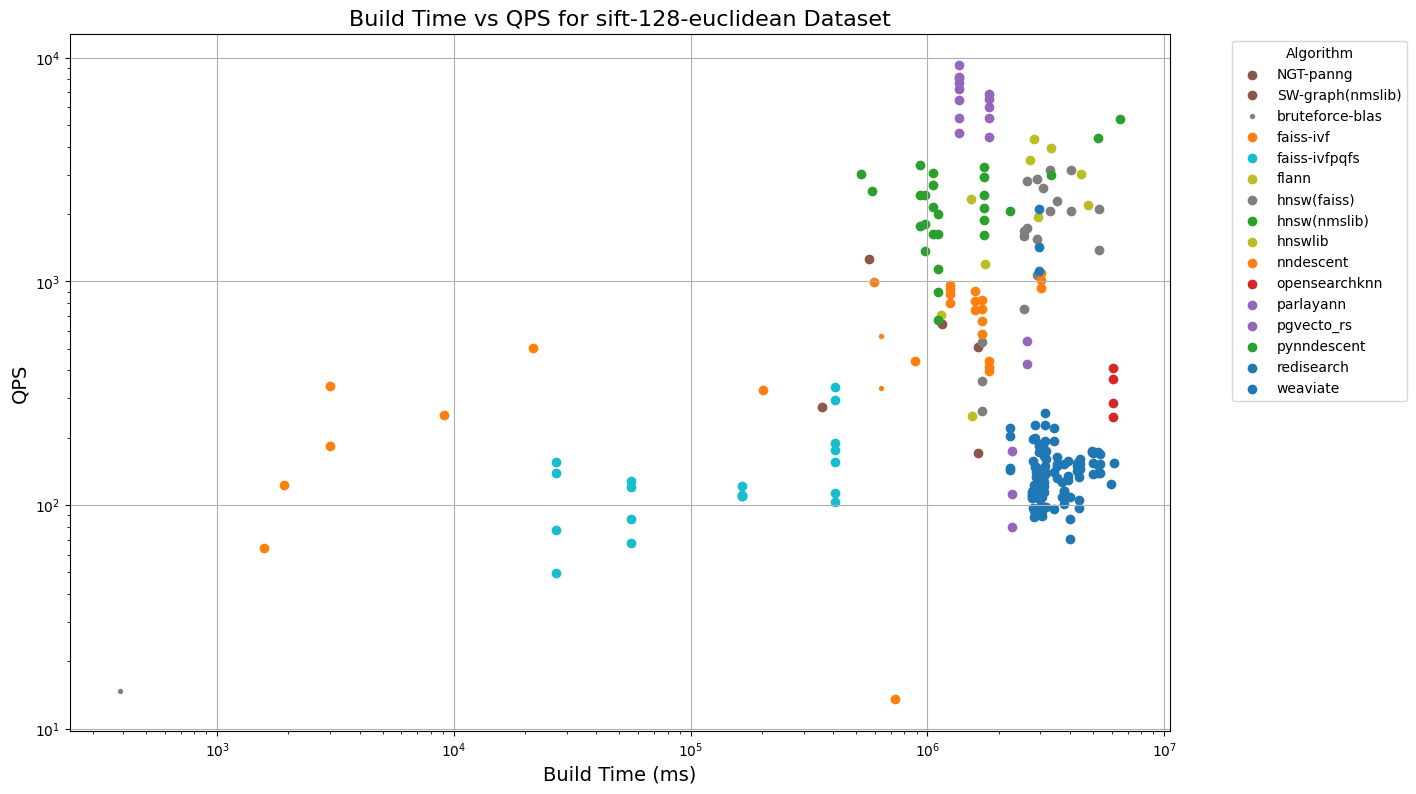

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming fdf is the DataFrame with the given columns
# fdf should be pre-loaded with data that includes columns like 'algorithm', 'parameters', 'qps', 'build', 'dataset', etc.

# Number of queries and query IDs
num_queries = 100
step = 1
start_qid = 0
query_ids = np.arange(start_qid, num_queries + 1, step)  # Adjust this to the number of queries you want to plot

# Create a color map: assign a unique color to each algorithm name
unique_algos = fdf['algorithm'].unique()
# Choose a colormap such as 'tab10', 'hsv', 'Set3', or 'tab20'
color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}

# Loop through each dataset
for dataset_name, dataset_df in fdf.groupby('dataset'):
    # Create a new plot for each dataset
    plt.figure(figsize=(12, 8))
    
    # Skip dataset if not in the list
    if dataset_name not in ['sift-128-euclidean']: continue
    
    # Set to track algorithms already plotted
    plotted_algos = set()

    # Loop through each algorithm and parameters within the dataset
    for (algo_name, params), group in dataset_df.groupby(['algorithm', 'parameters']):
        # Extract values for build time (in seconds) and qps for the current algorithm
        build_time = group['build'].iloc[0] * 1000  # Convert to ms (build time in seconds)
        qps = group['qps'].iloc[0]
        
        # Check if 'bruteforce-blas' is in the parameters
        if any(substring in params for substring in ['BruteForceBLAS()', 'FaissIVF(n_list=4096, n_probe=50)', 'FaissIVF(n_list=4096, n_probe=100)']):
            # Use a special marker for bruteforce-blas
            marker_style = 'o'  # Circle marker
            markersize = 8
        elif any(substring in algo_name for substring in ['hnsw(faiss)']):
            marker_style = None
            markersize = None
        else:
            # Use no marker for other algorithms
            marker_style = None
            markersize = None
        
        # Plot build time vs qps, color by parameters and special marker if applicable
        color = color_map[algo_name]  # Use the assigned color for this algorithm
        
        # Add to legend only once per algorithm
        if algo_name not in plotted_algos:
            label = algo_name  # Add label only the first time this algorithm is plotted
            plotted_algos.add(algo_name)
        else:
            label = None  # No label for subsequent occurrences of the same algorithm
        
        plt.scatter(build_time, qps, 
                    label=label,  # Only label the first occurrence
                    marker=marker_style, 
                    s=markersize,  # Size of the marker
                    color=color)  # Apply color based on algorithm name

    # Add labels, title, and legend
    plt.title(f'Build Time vs QPS for {dataset_name} Dataset', fontsize=16)
    plt.xlabel('Build Time (ms)', fontsize=14)
    plt.ylabel('QPS', fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Place the legend outside the plot
    plt.legend(title='Algorithm', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.yscale('log')
    plt.xscale('log')

    # Show the plot for the current dataset
    plt.show()


In [57]:
fdf.indexsize

16         5896.0
20         5896.0
23         5896.0
31         6016.0
39         5928.0
          ...    
2091     785208.0
2093     846920.0
2094    1221580.0
2099     785208.0
2113     756560.0
Name: indexsize, Length: 516, dtype: float64

/tmp/ipykernel_922510/926958552.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

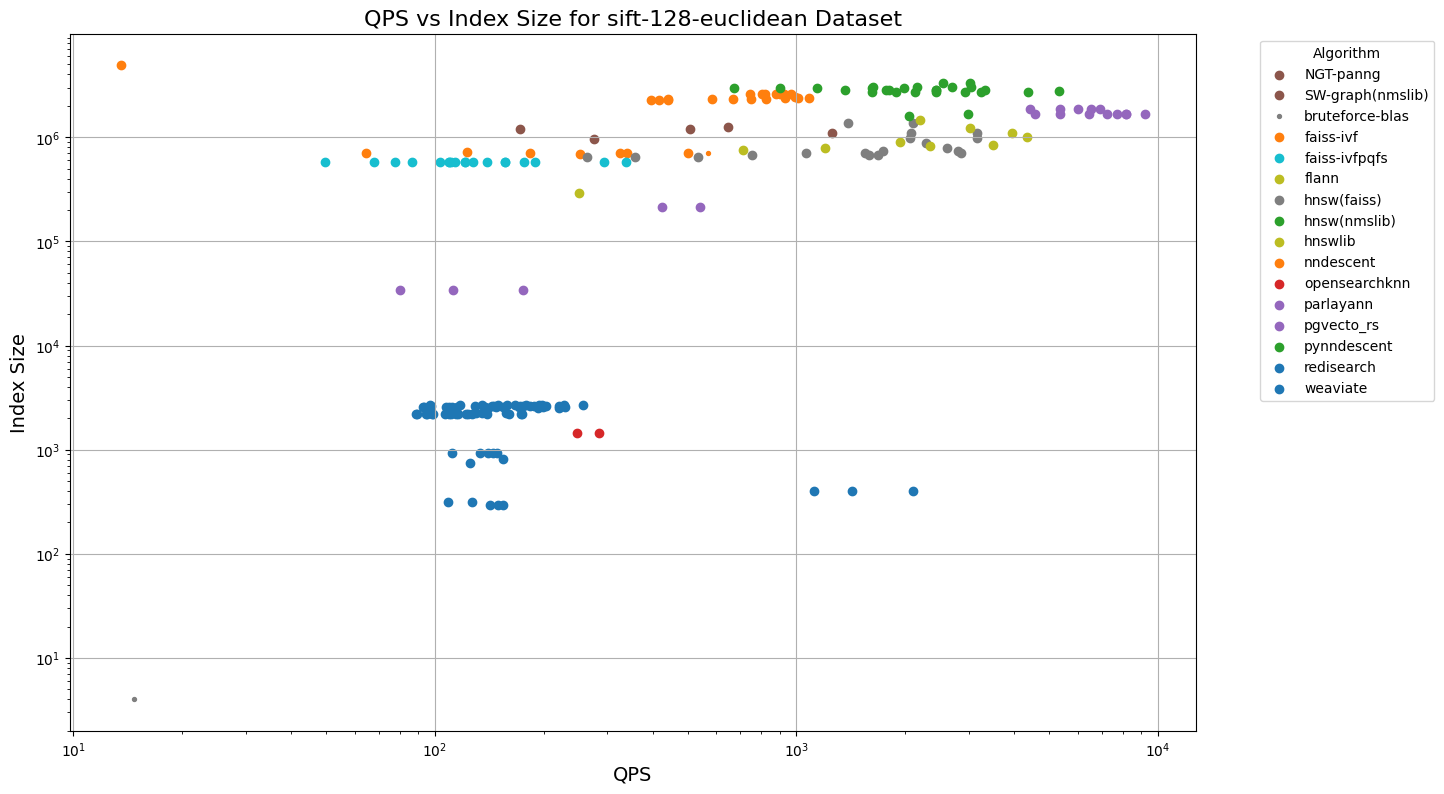

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming fdf is the DataFrame with the given columns
# fdf should be pre-loaded with data that includes columns like 'algorithm', 'parameters', 'qps', 'index_size', 'dataset', etc.

# Number of queries and query IDs
num_queries = 100
step = 1
start_qid = 0
query_ids = np.arange(start_qid, num_queries + 1, step)  # Adjust this to the number of queries you want to plot

# Create a color map: assign a unique color to each algorithm name
unique_algos = fdf['algorithm'].unique()
# Choose a colormap such as 'tab10', 'hsv', 'Set3', or 'tab20'
color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}

# Loop through each dataset
for dataset_name, dataset_df in fdf.groupby('dataset'):
    # Create a new plot for each dataset
    plt.figure(figsize=(12, 8))
    
    # Skip dataset if not in the list
    if dataset_name not in ['sift-128-euclidean']: continue
    
    # Set to track algorithms already plotted
    plotted_algos = set()

    # Loop through each algorithm and parameters within the dataset
    for (algo_name, params), group in dataset_df.groupby(['algorithm', 'parameters']):
        # Extract values for index size and qps for the current algorithm
        index_size = group['indexsize'].iloc[0]  # Assuming column 'indexsize' exists
        qps = group['qps'].iloc[0]
        
        # Check if 'bruteforce-blas' is in the parameters
        if any(substring in params for substring in ['BruteForceBLAS()', 'FaissIVF(n_list=4096, n_probe=50)', 'FaissIVF(n_list=4096, n_probe=100)']):
            # Use a special marker for bruteforce-blas
            marker_style = 'o'  # Circle marker
            markersize = 8
        elif any(substring in algo_name for substring in ['hnsw(faiss)']):
            marker_style = None
            markersize = None
        else:
            # Use no marker for other algorithms
            marker_style = None
            markersize = None
        
        # Plot QPS vs Index Size, color by parameters and special marker if applicable
        color = color_map[algo_name]  # Use the assigned color for this algorithm
        
        # Add to legend only once per algorithm
        if algo_name not in plotted_algos:
            label = algo_name  # Add label only the first time this algorithm is plotted
            plotted_algos.add(algo_name)
        else:
            label = None  # No label for subsequent occurrences of the same algorithm
        
        # Plot QPS vs Index Size
        plt.scatter(qps, index_size, 
                    label=label,  # Only label the first occurrence
                    marker=marker_style, 
                    s=markersize,  # Size of the marker
                    color=color)  # Apply color based on algorithm name

    # Add labels, title, and legend
    plt.title(f'QPS vs Index Size for {dataset_name} Dataset', fontsize=16)
    plt.xlabel('QPS', fontsize=14)
    plt.ylabel('Index Size', fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Place the legend outside the plot
    plt.legend(title='Algorithm', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set the x and y axes to logarithmic scale for better visualization (optional)
    plt.xscale('log')
    plt.yscale('log')

    # Show the plot for the current dataset
    plt.show()


/tmp/ipykernel_922510/3529474952.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

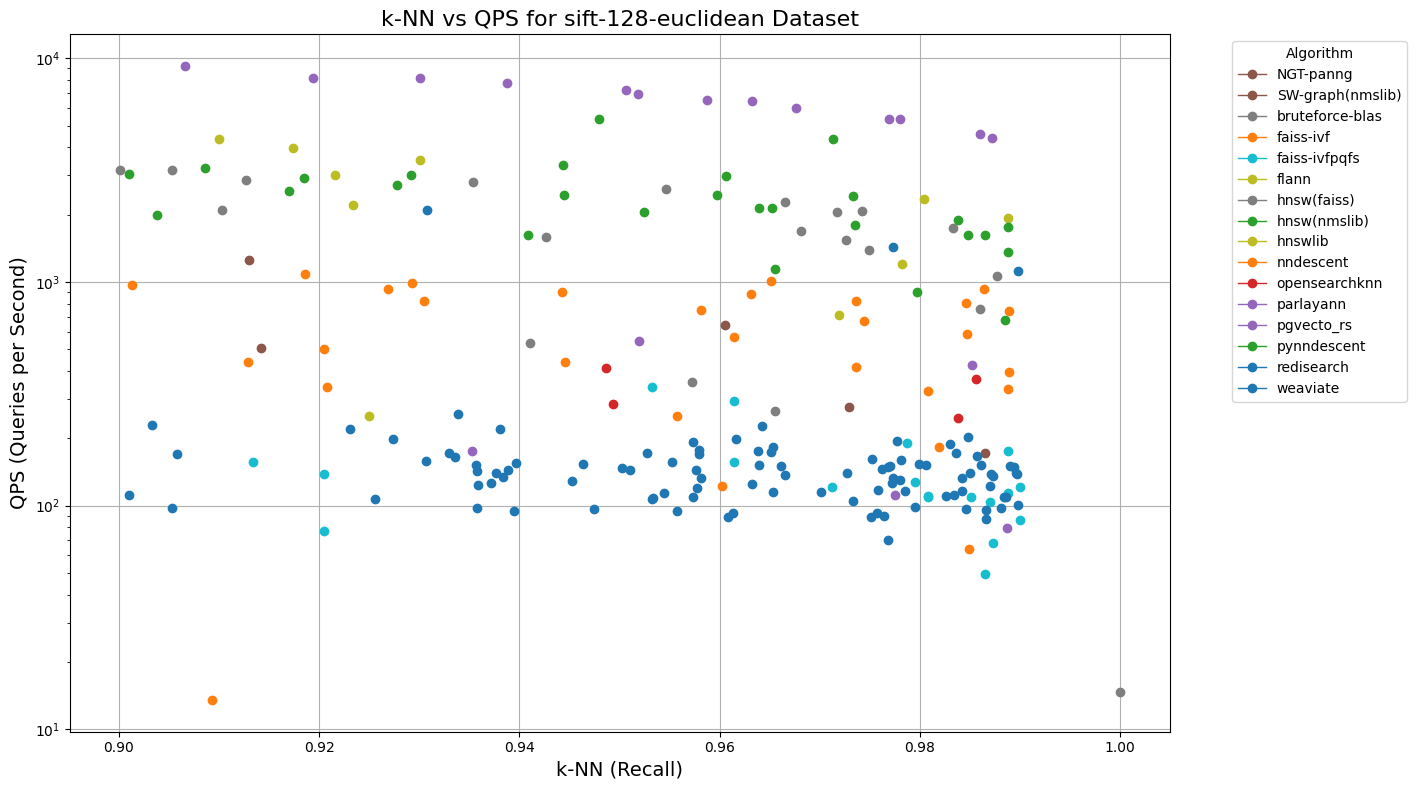

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming fdf is the DataFrame with the given columns
# fdf should be pre-loaded with data that includes columns like 'algorithm', 'parameters', 'qps', 'k-nn', 'dataset', etc.

# Number of queries and query IDs
num_queries = 100
step = 1
start_qid = 0
query_ids = np.arange(start_qid, num_queries + 1, step)  # if you want to skip some of them do num_queries + X (skip X to get the plot faster)

# Create a color map: assign a unique color to each algorithm name
unique_algos = fdf['algorithm'].unique()
# hsv, tab10, Set3, tab20
color_map = {algo: cm.get_cmap('tab10')(i / len(unique_algos)) for i, algo in enumerate(unique_algos)}

# Loop through each dataset
for dataset_name, dataset_df in fdf.groupby('dataset'):
    # Create a new plot for each dataset
    plt.figure(figsize=(12, 8))
    
    # Skip dataset if not in the list
    if dataset_name not in ['sift-128-euclidean']: continue
    
    # Set to track algorithms already plotted
    plotted_algos = set()

    # Loop through each algorithm and parameters within the dataset
    for (algo_name, params), group in dataset_df.groupby(['algorithm', 'parameters']):
        # Extract values for k-NN and qps for the current algorithm
        knn = group['k-nn'].iloc[0]  # k-NN (Recall)
        qps = group['qps'].iloc[0]
        
        # Plot k-NN vs QPS, color by parameters and special marker if applicable
        color = color_map[algo_name]  # Use the assigned color for this algorithm
        
        # Add to legend only once per algorithm
        if algo_name not in plotted_algos:
            label = algo_name  # Add label only the first time this algorithm is plotted
            plotted_algos.add(algo_name)
        else:
            label = None  # No label for subsequent occurrences of the same algorithm
        
        plt.plot(knn, qps, 
                 label=label,  # Only label the first occurrence
                 linestyle='-', 
                 marker='o',  # Circle marker for visibility
                 markersize=6, 
                 linewidth=1, 
                 color=color)  # Apply color based on algorithm name

    # Add labels, title, and legend
    plt.title(f'k-NN vs QPS for {dataset_name} Dataset', fontsize=16)
    plt.xlabel('k-NN (Recall)', fontsize=14)
    plt.ylabel('QPS (Queries per Second)', fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Place the legend outside the plot
    plt.legend(title='Algorithm', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set the y-axis to logarithmic scale
    plt.yscale('log')

    # Show the plot for the current dataset
    plt.show()


In [47]:
fdf.parameters.unique()

array(['FaissIVF(n_list=256, n_probe=5)',
       'FaissIVF(n_list=512, n_probe=5)', 'BruteForceBLAS()',
       "faiss ({'M': 64, 'efConstruction': 500}, ef: 20)",
       "faiss ({'M': 64, 'efConstruction': 500}, ef: 10)",
       "faiss ({'M': 16, 'efConstruction': 500}, ef: 10)",
       "faiss ({'M': 12, 'efConstruction': 500}, ef: 20)",
       "faiss ({'M': 96, 'efConstruction': 500}, ef: 20)",
       "faiss ({'M': 4, 'efConstruction': 500}, ef: 80)",
       "faiss ({'M': 36, 'efConstruction': 500}, ef: 20)",
       "faiss ({'M': 8, 'efConstruction': 500}, ef: 20)",
       "faiss ({'M': 4, 'efConstruction': 500}, ef: 120)",
       "faiss ({'M': 48, 'efConstruction': 500}, ef: 20)",
       "faiss ({'M': 24, 'efConstruction': 500}, ef: 20)",
       "faiss ({'M': 96, 'efConstruction': 500}, ef: 10)",
       "faiss ({'M': 4, 'efConstruction': 500}, ef: 40)",
       "faiss ({'M': 24, 'efConstruction': 500}, ef: 10)",
       "faiss ({'M': 48, 'efConstruction': 500}, ef: 10)",
       "faiss 

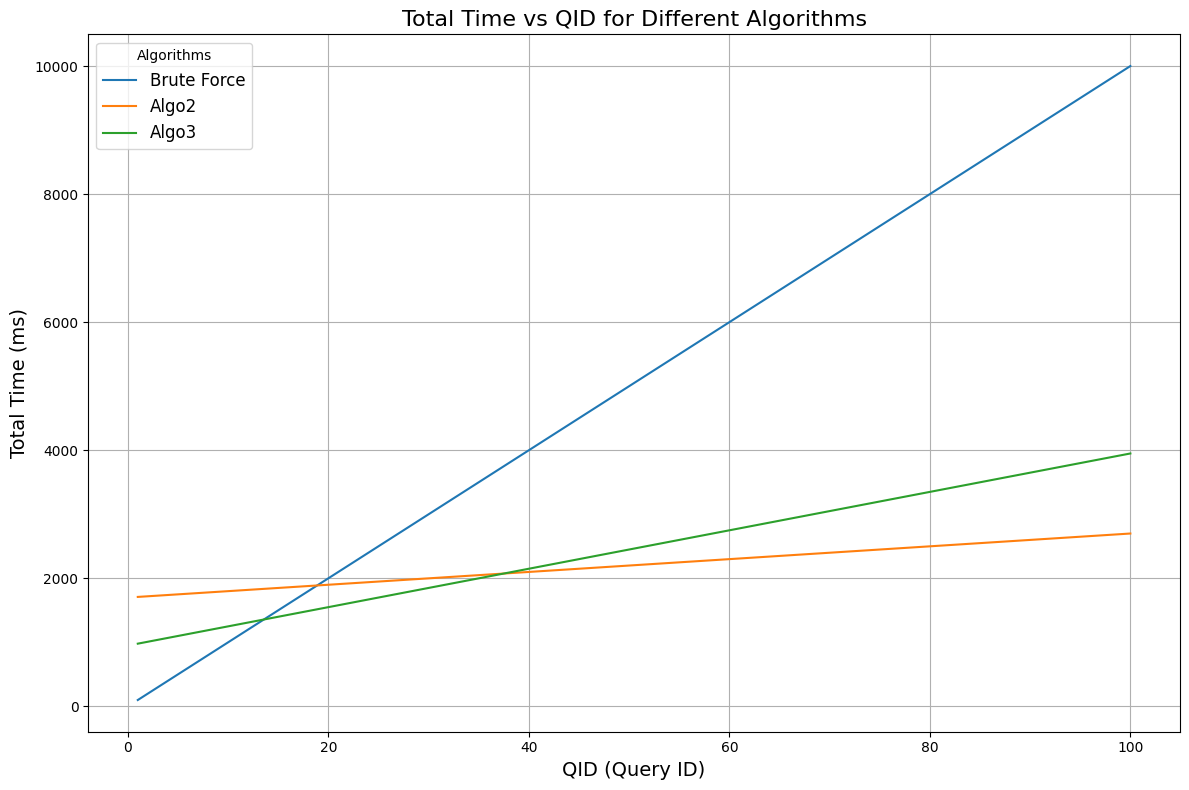

In [7]:

# Specify data for algorithms
# Format: {'algo_name': {'build_time': X, 'add_time': Y, 'search_time_per_query': Z}}
algorithms = {
    'Brute Force': {'build_time': 0, 'add_time': 0, 'search_time_per_query': 100},
    'Algo2': {'build_time': 1200, 'add_time': 500, 'search_time_per_query': 10},
    'Algo3': {'build_time': 900, 'add_time': 50, 'search_time_per_query': 30},
}

# Number of queries and query IDs
num_queries = 100
query_ids = np.arange(1, num_queries + 1)

# Create a new plot
plt.figure(figsize=(12, 8))

# Loop through each algorithm to compute and plot total time
for algo_name, times in algorithms.items():
    build_time = times['build_time']
    add_time = times['add_time']
    search_time_per_query = times['search_time_per_query']
    
    # Compute total time for each query
    total_time = build_time + add_time + search_time_per_query * query_ids
    
    # Plot total time vs. query ID
    plt.plot(query_ids, total_time, linestyle='-', label=algo_name) # , marker='0'

# Add labels, title, and legend
plt.title('Total Time vs QID for Different Algorithms', fontsize=16)
plt.xlabel('QID (Query ID)', fontsize=14)
plt.ylabel('Total Time (ms)', fontsize=14)
plt.legend(title='Algorithms', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
